In [1]:
import os,tables,numpy as np,matplotlib.pyplot as plt,pandas as pd,json,h5py
from scipy.io import loadmat
from collections import Counter
from  itertools import combinations
#from dataholder import Data
import random,pickle

In [2]:
os.getcwd()

'/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes'

['fold_a.mat']

In [4]:
for x in os.listdir(fold_dir):
    data = h5py.File(fold_dir+x, 'r')
    print(x,list(data.keys()))

fold_a.mat ['#refs#', 'diastole', 's1', 's2', 'systole', 'trainY', 'train_files', 'train_parts', 'wav_name']


In [5]:
data = h5py.File(fold_dir+'fold_a.mat', 'r')
print(x,list(data.keys()))

fold_a.mat ['#refs#', 'diastole', 's1', 's2', 'systole', 'trainY', 'train_files', 'train_parts', 'wav_name']


In [75]:
path = '/media/mhealthra2/Data/heart_sound/Adversarial Heart Sound Results/logs/SmallNet/self_train/a repeated 0 0 400 2019-11-18 15:36:10.354170/params.pickle'

In [87]:
with open(path, "rb") as output_file:
    hm = pickle.load(output_file)

In [90]:
hm,['bn_momentum',
                 'l2_reg',
                 'l2_reg_dense',
                 'kernel_size',
                 'maxnorm',
                 'dropout_rate',
                 'dropout_rate_dense',
                 'padding',
                 'activation_function',
                 'subsam',
                 'FIR_train',
                 'trainable',
                 'optim',
                 'equ']

((0.99,
  0.1486491106509375,
  0.01,
  5,
  10000.0,
  0.5,
  0.2,
  'valid',
  'relu',
  2,
  True,
  True),
 ['bn_momentum',
  'l2_reg',
  'l2_reg_dense',
  'kernel_size',
  'maxnorm',
  'dropout_rate',
  'dropout_rate_dense',
  'padding',
  'activation_function',
  'subsam',
  'FIR_train',
  'trainable',
  'optim',
  'equ'])

In [16]:
d = Data(fold_dir,'fold_a.mat','a',split=0.3,shuffle=0)

../../feature/potes_1DCNN/balancedCV/folds/individual_fold_4_segments/


In [17]:
d.trainY.shape

(11792,)

In [18]:
[d.trainX[k].shape for k in d.segments]

[(200, 11792), (800, 11792), (200, 11792), (1700, 11792)]

In [14]:
'4_segments' in 'nasidf4_segmentsasdf'

True

In [5]:
import matplotlib.pyplot as plt,h5py,numpy as np,random
from collections import Counter
class Data():
    def __init__(self,path,f,n,severe = True,split=0,normalize=False,shuffle=None):
        
        if(split>=1 or split<0):
            print("make sure split follow  1<split<=0 ")
            raise ValueError
        self.split = split
        self.data = h5py.File(path+f, 'r')
        self.file = f
        self.dom = n
        self.segments = ['s1','systole','s2','diastole']
        print(path)
        self.seg = ('4_segments' in path)
        if(self.seg):
            self.trainX = {k:np.array(self.data[k][:]).astype('float32') for k in self.segments}
        else:
            self.trainX = np.array(self.data['trainX'][:]).astype('float32')
        self.trainY = self.data['trainY'][:][0].astype('int8')
        self.train_parts = self.data['train_parts'][0].astype('int32')
        self.wav_name = [''.join([chr(c[0]) for c in self.data[stp]]) for stp in self.data['wav_name'][0]]
        self.valX = None
        self.valY = None
        self.val_wav_name = None
        self.valdomY = None
        self.val_parts = None
        self.domainY = [n]*self.trainY.shape[0]
        ##calculate the normal and abnormal beats count
        self.normal = Counter(self.trainY)[0]
        self.abnormal = Counter(self.trainY)[1]
        self.total = self.normal+self.abnormal
        self.normfiles, self.abnormfiles = self.parts() 
        
        if(f[:3]=='com'):self.processCompare(severe) ### select severe files only
        else:
            self.trainY[self.trainY<0] = 0   
        if('fold_e' in f):self.processE()
        if(shuffle is not None):self.shuffle_data(shuffle)
        if(split>0):self.split_data(split)
        if(normalize):self.normalize_data()
        if(False):self.cutoff()
    def shuffle_data(self,seed=0):
        ## The shuffle parameter is None in init(). but if provided and int value it will be
        ## used as the random seed
        if(self.trainX is not None):
            xx = self.trainX.copy()
            yy = self.trainY.copy()
            pr = [x for x in range(len(self.train_parts))]
            random.Random(seed).shuffle(pr)
            s = 0
            for i,x in enumerate(pr):
                if(self.seg):
                    for k in self.segments:
                        xx[k][:,s:s+self.train_parts[x]] = self.trainX[k][:,sum(self.train_parts[:x]):sum(self.train_parts[:x])+self.train_parts[x]]
                else:
                    xx[:,s:s+self.train_parts[x]] = self.trainX[:,sum(self.train_parts[:x]):sum(self.train_parts[:x])+self.train_parts[x]]
                yy[s:s+self.train_parts[x]] = self.trainY[sum(self.train_parts[:x]):sum(self.train_parts[:x])+self.train_parts[x]]
                s = s+self.train_parts[x]
            self.train_parts = self.train_parts[pr]
            self.wav_name = [self.wav_name[pr[x]] for x in range(len(self.wav_name))]
        if(self.valX is not None):
            xx = self.valX.copy()
            yy = self.valY.copy()
            pr = [x for x in range(len(self.val_parts))]
            random.Random(seed).shuffle(pr)
            s = 0
            for i,x in enumerate(pr):
                if(self.seg):
                    xx[k][:,s:s+self.train_parts[x]] = self.valX[k][:,sum(self.train_parts[:x]):sum(self.train_parts[:x])+self.train_parts[x]]
                else:
                    xx[:,s:s+self.train_parts[x]] = self.valX[:,sum(self.train_parts[:x]):sum(self.train_parts[:x])+self.train_parts[x]]
                yy[s:s+self.train_parts[x]] = self.valY[sum(self.train_parts[:x]):sum(self.train_parts[:x])+self.train_parts[x]]
                s = s+self.train_parts[x]
            self.train_parts = self.val_parts[pr]
            self.val_wav_name = [self.val_wav_name[pr[x]] for x in range(len(self.val_wav_name))]
    def normalize_data(self):
        self.trainX = np.array([x/(max(abs(x)+10e-6)) for x in self.trainX.transpose()]).transpose()
    def cutoff(self):
        self.trainX = np.array([self.cut(x)  for x in self.trainX.transpose()]).transpose()
    def cut(self,x):
        mean = np.mean(x)
        std = np.std(x)
        x[x>(mean+std*2)] = (mean+std*2)
        x[x<(mean-std*2)] = (mean-std*2)
        return x
    def split_data(self,split):
        if(self.file[:3]=='com'):
            self.valX = self.data['valX'][:]
            self.valY = self.data['valY'][:][0]
            self.valY[self.valY>0] = 1
            self.val_parts = self.data['val_parts'][0].astype('int32')
            self.valdomY = [self.dom]*self.valY.shape[0]
            return
        taken = 0
        left = 0
        tmpX = None
        tmpY = None
        parts = []
        wav_name = []
        self.val_wav_name = []
        
        self.val_parts = []
        for j,x in enumerate(self.train_parts):
            if(taken<split*self.total):
                taken = taken + x
                if(self.valX is None):
                    if(self.seg):
                        self.valX = {k:self.trainX[k][:,left:x+left] for k in self.segments}
                    else:
                        self.valX = self.trainX[:,left:x+left]
                    self.valY = self.trainY[left:x+left]
                else:
                    if(self.seg):
                        self.valX = {k:np.concatenate((self.valX[k],self.trainX[k][:,left:x+left]),axis=1) for k in self.segments}
                    else:
                        self.valX = np.concatenate((self.valX,self.trainX[:,left:x+left]),axis=1)
                    self.valY = np.concatenate((self.valY,self.trainY[left:x+left]),axis=0)
                self.val_parts.append(x)
                self.val_wav_name.append(self.wav_name[j])
            else:
                if(tmpX is None):
                    if(self.seg):
                        tmpX = {k:self.trainX[k][:,left:x+left] for k in self.segments}
                    else:
                        tmpX = self.trainX[:,left:x+left]
                    tmpY = self.trainY[left:x+left]
                else:
                    if(self.seg):
                        tmpX = {k:np.concatenate((tmpX[k],self.trainX[k][:,left:x+left]),axis=1) for k in self.segments}
                    else:
                        tmpX = np.concatenate((tmpX,self.trainX[:,left:x+left]),axis=1)
                    tmpY = np.concatenate((tmpY,self.trainY[left:x+left]),axis=0)
                parts.append(x)
                wav_name.append(self.wav_name[j])
            left = left + x
        self.trainX = tmpX
        self.trainY = tmpY
        self.train_parts = parts
        self.wav_name = wav_name
        self.domainY = [self.dom]*self.trainY.shape[0]
        self.valdomY = [self.dom]*self.valY.shape[0]
        del tmpX,tmpY,parts
    def processCompare(self,severe):
        if(severe):
            print("fixed implementation, normal = 0, mild = 1, sever = 2. mild is being selected")
            self.sevX = None
            self.sevY = self.trainY[self.trainY%2==0]
            self.sev_parts = []
            self.sev_wav_name = []
            left = int(0)
            for j,x in enumerate(self.train_parts):
                x = int(x)
                if(all([i%2==0 for i in self.trainY[left:x+left]])):
                    if(self.sevX is None):
                        self.sevX = self.trainX[:,left:x+left]
                    else: 
                        self.sevX = np.concatenate((self.sevX,self.trainX[:,left:x+left]),axis=1)
                    self.sev_parts.append(x)
                    self.sev_wav_name.append(self.wav_name[j])
                left = x + left
                
            self.trainX = self.sevX
            self.trainY = self.sevY
            self.train_parts = self.sev_parts
            self.domainY = [self.dom]*self.trainY.shape[0]
            self.normal = Counter(self.trainY)[0]
            self.abnormal = Counter(self.trainY)[1]
            self.total = self.normal+self.abnormal
            self.normfiles, self.abnormfiles = self.parts()
        else:
            self.trainY[self.trainY>0] = 1
    def processE(self):
        self.trainY[self.trainY<0] = 0
        nn = ab = 0
        idx = []
        left = 0
        parts = []
        wav_name = []
        for j,x in enumerate(self.train_parts):
            if(all([(l == 0) for l in self.trainY[left:left+x]])):
                if(nn<self.abnormal):
                    idx = idx + [True]*x
                    nn = nn + x
                    parts.append(x)
                    wav_name.append(self.wav_name[j])
                else:idx = idx + [False]*x
            else:
                if(ab<self.abnormal):
                    idx = idx + [True]*x
                    ab = ab + x
                    parts.append(x)
                    wav_name.append(self.wav_name[j])
                else:idx = idx + [False]*x
            left = left + x
        self.trainY = self.trainY[idx]
        self.trainX = np.transpose(np.transpose(self.trainX)[idx])
        self.train_parts = parts
        self.wav_name = wav_name
        self.total = nn+ab
        self.domainY = self.domainY[:self.total]
    def parts(self):
        y = 0
        nn = 0
        ab = 0
        for x in self.train_parts:
            if(sum(self.trainY[y:y+int(x)])>0):
                ab = ab + 1
            else: nn = nn +1 
            y = int(x)+y
        #print(nn+ab,nn,ab)
        return nn,ab
    def pie(self):
        colors = ['gold','lightskyblue']
        explode = (0.07, 0)
        size = [self.normal,self.abnormal]
        labels = ['N', 'Ab']
        plt.pie(size,labels=labels,colors = colors,startangle=140,explode=explode,
               shadow=True,autopct=self.value)
        plt.title(self.dom)
    def value(self,val):
        return int(self.total*val/100)
    def details(self):
        if(self.trainX is  None):print("TrainX None/ ",end='')
        if(self.trainY is  None):print("trainY None/ ",end='')
        if(self.domainY is None):print("Dom Y/ ",end='')
        if(self.train_parts is  None):print("train parts/ ")
        if(self.valX is None):print("valX/ ",end='')
        if(self.valY is None) :print("valY/ ",end='')
        if(self.valdomY is None):print("Valdom/ ",end='')
        if(self.val_parts is  None):print("val parts/ ")

In [74]:
d.trainX.shape, d.trainY.shape

((2500, 14167), (14167,))

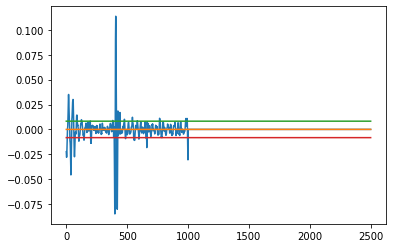

In [39]:
plt.plot(d.trainX[:,1])
plt.plot([x for x in range(2500)],np.mean(d.trainX[:,1])*np.ones(2500))
plt.plot([x for x in range(2500)],(np.std(d.trainX[:,1])+np.mean(d.trainX[:,1]))*np.ones(2500))
plt.plot([x for x in range(2500)],(-np.std(d.trainX[:,1])+np.mean(d.trainX[:,1]))*np.ones(2500))

In [42]:
std = np.std(d.trainX[:,1])
mean = np.mean(d.trainX[:,1])
x = d.trainX[:,1]

(2500,)


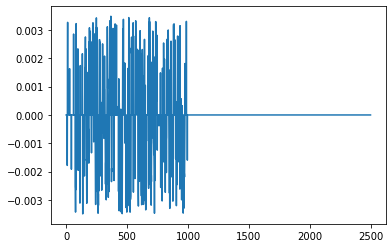

In [71]:
mean = np.mean(x)
std = np.std(x)
x[x>(mean+std*2)] = (mean+std*2)
x[x<(mean-std*2)] = (mean-std*2)


In [ ]:
combinations(dd.train_parts)

In [13]:
import os,tables,numpy as np,matplotlib.pyplot as plt,pandas as pd,h5py,json
from scipy.io import loadmat
from collections import Counter
#from  dataholder import Data

class DataMerge():
    def __init__(self,split = 0):
        self.split = split
        self.x_train = self.y_train = self.y_domain = self.train_parts = None
        self.x_val = self.y_val = self.y_valdom = self.val_parts = None
        self.val_wav_name = None
        #self.train_normal, self.train_abnormal, self.val_normal, self.val_abnormal = 0
        #self.train_total , self.val_total = 0
    def merge(self,data,train_test):
        if(train_test):
            if(self.x_val is None):self.x_val = data.trainX;
            elif(data.seg):self.x_val = {k:np.concatenate((self.x_val[k],data.trainX[k]),axis = 1) for k in data.segments}
            else:self.x_val = np.concatenate((self.x_val,data.trainX),axis = 1)
                
            if(self.y_val is None):self.y_val = data.trainY
            else:self.y_val = np.concatenate((self.y_val,data.trainY),axis = 0)
                
            if(self.y_valdom is None):self.y_valdom = data.domainY
            else:self.y_valdom = self.y_valdom+data.domainY
            if(self.val_parts is None):
                if(data.train_parts is not None):self.val_parts = data.train_parts
            else:
                if(data.train_parts is not None):
                    self.val_parts = np.concatenate((self.val_parts,data.train_parts),axis = 0)
                else:
                    print("Data train parts unavailable")
            if(self.val_wav_name is None):
                self.val_wav_name = data.wav_name
            else:
                self.val_wav_name = self.val_wav_name+data.wav_name
            if(self.split>0):        
                if(self.x_train is None):self.x_train = data.valX
                elif(data.seg):self.x_train = {k:np.concatenate((self.x_train[k],data.valX[k]),axis = 1) for k in data.segments}
                else:self.x_train = np.concatenate((self.x_train,data.valX),axis = 1)
                    
                if(self.y_train is None):self.y_train =  data.valY
                else:self.y_train = np.concatenate((self.y_train,data.valY),axis = 0)
                if(self.y_domain is None):self.y_domain  =  data.valdomY
                else:self.y_domain = self.y_domain+data.valdomY
                if(self.train_parts is None):self.train_parts = data.val_parts;
                else:
                    if(data.val_parts is not None):
                        self.train_parts = np.concatenate((self.train_parts,data.val_parts),axis = 0) 
                    else:
                        print("Data train parts unavailable")

        else:
            
            if(self.x_train is None):self.x_train = data.trainX;
            elif(self.seg):self.x_train = {k:np.concatenate((self.x_train[k],data.trainX[k]),axis = 1) for k in self.segments}
            else:self.x_train = np.concatenate((self.x_train,data.trainX),axis = 1)
            if(self.y_train is None):self.y_train = data.trainY;
            else:self.y_train = np.concatenate((self.y_train,data.trainY),axis = 0)
            if(self.y_domain is None):self.y_domain = data.domainY;
            else:self.y_domain = self.y_domain+data.domainY
            if(self.train_parts is None):
                self.train_parts = data.train_parts;
            else:
                if(data.train_parts is not None):
                    self.train_parts = np.concatenate((self.train_parts,data.train_parts),axis = 0) 
                else:
                    print("Data train parts nai Train mergee ")

    def showDistribution(self):
        self.train_normal = Counter(self.y_train)[0]
        self.train_abnormal = Counter(self.y_train)[1]
        self.train_total = self.train_normal+self.train_abnormal

        self.val_normal = Counter(self.y_val)[0]
        self.val_abnormal = Counter(self.y_val)[1]
        self.val_total = self.val_normal+self.val_abnormal
        print("Train normal - ", self.train_normal,"-",self.train_abnormal," Abnormal")
        print("               ", int(100*self.train_normal/self.train_total) , " - ", int(100*self.train_abnormal/self.train_total), "%")
        print("Test normal - ", self.val_normal,"-",self.val_abnormal," Abnormal")
        print("              ",int(100*self.val_normal/self.val_total) , " - ", int(100*self.val_abnormal/self.val_total), "%")


def getData(fold_dir, train_folds, test_folds, split = 0, shuffle = None):
    try:
        with open('../data/domain_filename.json', 'r') as fp:
            foldname = json.load(fp)
    except:
        raise FileNotFoundError("The json file in Data folder of the repository, that maps domain character to filename is not here")

    allData = DataMerge(split)
    for c in test_folds:
        allData.merge(Data(fold_dir,foldname[c],c,severe = False,split=split,shuffle=shuffle),True)
    for c in train_folds:
        allData.merge(Data(fold_dir,foldname[c],c,shuffle=shuffle),False)
    allData.showDistribution()
    return allData.x_train, allData.y_train, allData.y_domain, allData.train_parts,allData.x_val,allData.y_val,allData.y_valdom,allData.val_parts,allData.val_wav_name


def reshape_folds(x, y):
    x_train = []
    for x1 in x:
        if(isinstance(x1,dict)):
            xD = {}
            for k in x1.keys():
                xd = np.transpose(x1[k][:, :])
                xd = np.reshape(xd, [xd.shape[0], xd.shape[1], 1])
                xD[k] = xd
                print("reshaped x_dict ", xd.shape)
            x_train.append(xD)
        else:
            x1 = np.transpose(x1[:, :])
            x1 = np.reshape(x1, [x1.shape[0], x1.shape[1], 1])
            x_train.append(x1)
            print("reshaped x ", x1.shape)
    y_train = []
    for y1 in y:
        y1 = np.reshape(y1, [y1.shape[0], 1])
        y_train.append(y1)
        print("reshaped Y ", y1.shape)

    return x_train,y_train



In [12]:
hm = getData(fold_dir,'','a',split=0.3)

../../feature/potes_1DCNN/balancedCV/folds/individual_fold_4_segments/
Train normal -  934 - 2257  Abnormal
                29  -  70 %
Test normal -  3480 - 8321  Abnormal
               29  -  70 %


In [20]:
u,i,o,p,uu,ii,oo,pp = getData(fold_dir,'abcdefgh','i',split = 0.0)

testc i
HMM
train  a
train  b
train  c
train  d
train  e
train  f
train  g
train  h


In [130]:
u.shape, uu.shape

((2500, 20275), (2500, 4159))

In [133]:
u.shape, uu.shape

((2500, 19734), (2500, 4700))

In [15]:
fails = ['fold_a.mat',
 'fold_b.mat',
 'fold_c.mat',
 'fold_d.mat',
 'fold_e.mat',
 'fold_f.mat',
 'pascalA.mat',
 'pascalB.mat',
 'compare.mat']

In [18]:
for (x,n) in zip(fails,'abcdefghi'):
    d = Data(fold_dir,x,n,split=0.0)
    print(x)
    d.details()
    d.types()

fold_a.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'numpy.ndarray'>
fold_b.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'numpy.ndarray'>
fold_c.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'numpy.ndarray'>
fold_d.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'numpy.ndarray'>
fold_e.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'list'>
fold_f.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'numpy.ndarray'>
pascalA.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'> <class 'numpy.ndarray'>
pascalB.mat
valX/ valY/ Valdom/ val parts/ 
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class

In [98]:
ww = [2,2,2,2]
all([x==2 for x in ww])

True

In [101]:
'fold_e' in "fold_e_dfasfd"

True